**This is the notebook for the practical part of lab 1.** 

Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from gensim.models import KeyedVectors
import gensim.downloader as api
from gensim.models import Word2Vec
import re
import copy

#import data_loading_code as dlc

In [2]:
print(torch.cuda.is_available())
#print(torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

False
Using device: cpu


## Load data

In [3]:
def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers
    # for index, row in data.iterrows():
    #     word_tokens = word_tokenize(row['Sentence'])
    #     filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
    #     df_.loc[len(df_)] = {
    #         "index": row['index'],
    #         "Class": row['Class'],
    #         "Sentence": " ".join(filtered_sent)
    #     }
    #return df_
    return data

small dataset

In [4]:
# get and pre-process data 
data = pd.read_csv("amazon_cells_labelled.txt", delimiter='\t', header=None)

data.columns = ['Sentence', 'Class']
data['index'] = data.index # add new column index
columns = ['index', 'Class', 'Sentence']
data = preprocess_pandas(data, columns) # pre-process

# split the data into training, validation, and test splits
# first get 50% for training
X_train, X_rest, y_train, y_rest = train_test_split(
    data['Sentence'].values.astype('U'),
    data['Class'].values.astype('int32'),
    test_size=0.5,
    random_state=0,
    shuffle=True
)

# split rest to get 50/20/30 split
X_val, X_test, y_val, y_test = train_test_split(
    X_rest,
    y_rest,
    test_size=0.6,  # 60% of 50% = 30% test
    random_state=0,
    shuffle=True
)

large dataset

In [5]:
data_large = pd.read_csv("amazon_cells_labelled_LARGE_25K.txt", delimiter='\t', header=None)
data_large.columns = ['Sentence', 'Class']
data_large['index'] = data_large.index
data_large = preprocess_pandas(data_large, columns)

X_train_l, X_rest_l, y_train_l, y_rest_l = train_test_split(
    data_large['Sentence'].values.astype('U'),
    data_large['Class'].values.astype('int32'),
    test_size=0.5,
    random_state=42,
    shuffle=True
)

X_val_l, X_test_l, y_val_l, y_test_l = train_test_split(
    X_rest_l, y_rest_l, test_size=0.6, random_state=42, shuffle=True
)

## Vectorise using tfidf

small dataset

In [6]:
# vectorize data using TFIDF and transform for PyTorch for scalability
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')

X_train_vec = word_vectorizer.fit_transform(X_train).todense() # transform texts to sparse matrix and then to dense matrix for Pytorch
X_val_vec = word_vectorizer.transform(X_val).todense()
X_test_vec = word_vectorizer.transform(X_test).todense()

# convert to tensors
train_x_tensor = torch.from_numpy(np.array(X_train_vec)).type(torch.FloatTensor)
train_y_tensor = torch.from_numpy(np.array(y_train)).type(torch.FloatTensor)

val_x_tensor = torch.from_numpy(np.array(X_val_vec)).type(torch.FloatTensor)
val_y_tensor = torch.from_numpy(np.array(y_val)).type(torch.FloatTensor)

test_x_tensor = torch.from_numpy(np.array(X_test_vec)).type(torch.FloatTensor)
test_y_tensor = torch.from_numpy(np.array(y_test)).type(torch.FloatTensor)

# Build datasets and DataLoader
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
val_dataset = TensorDataset(val_x_tensor, val_y_tensor)
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

large dataset

In [7]:
# vectorize data using TFIDF and transform for PyTorch for scalability
vectorizer_large = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')

X_train_l_vec = vectorizer_large.fit_transform(X_train_l).todense()
X_val_l_vec = vectorizer_large.transform(X_val_l).todense()
X_test_l_vec = vectorizer_large.transform(X_test_l).todense()

# convert to tensors
train_x_tensor_l = torch.from_numpy(np.array(X_train_l_vec)).type(torch.FloatTensor)
train_y_tensor_l = torch.from_numpy(np.array(y_train_l)).type(torch.FloatTensor)
val_x_tensor_l = torch.from_numpy(np.array(X_val_l_vec)).type(torch.FloatTensor)
val_y_tensor_l = torch.from_numpy(np.array(y_val_l)).type(torch.FloatTensor)
test_x_tensor_l = torch.from_numpy(np.array(X_test_l_vec)).type(torch.FloatTensor)
test_y_tensor_l = torch.from_numpy(np.array(y_test_l)).type(torch.FloatTensor)

# build datasets and DataLoader
train_loader_large = DataLoader(TensorDataset(train_x_tensor_l, train_y_tensor_l), batch_size=32, shuffle=True)
val_loader_large = DataLoader(TensorDataset(val_x_tensor_l, val_y_tensor_l), batch_size=32, shuffle=False)
test_loader_large = DataLoader(TensorDataset(test_x_tensor_l, test_y_tensor_l), batch_size=32, shuffle=False)

## Sentence embeddings using Word2Vec for vectorization

In [8]:
# # load pretrained word2vec model with dimension 100
# word2vec_model = api.load("glove-wiki-gigaword-100")
# embedding_dim = 100 

In [9]:
# sentences = list(X_train) + list(X_val) + list(X_test)

# # Tokenize sentences
# tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]

In [10]:
sentences = list(X_train_l) + list(X_val_l) + list(X_test_l)

# Tokenize sentences
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]

In [11]:
# Train Word2Vec 
word2vec_model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=100,       # dimension of vectors
    window=5,              
    min_count=1,           # min. appearance of a word in dataset
    workers=4,             
    sg=0                   # 1 = skip-gram, 0 = CBOW
)

In [12]:
# Function to convert sentences into embeddings
def sentence_to_vec(sentence, model, embedding_dim=100):
    words = sentence.split()
    vec = torch.zeros(embedding_dim)
    word_count = 0
    for word in words:
        if word in model.wv:
            vec += torch.tensor(model.wv[word])
            word_count += 1
    if word_count > 0:
        vec /= word_count
    return vec

# Convert all sentences to embeddings for the datasets
def create_dataset(X, y, word2vec_model, embedding_dim=100):
    x_tensor = torch.stack([sentence_to_vec(sentence, word2vec_model, embedding_dim) for sentence in X])
    y_tensor = torch.tensor(y, dtype=torch.float32)  # Binary labels as float32
    return x_tensor, y_tensor

small dataset

In [13]:
# # Convert all sentences to embeddings for the datasets
# train_x_tensor_w2v = torch.stack([sentence_to_vec(sentence, word2vec_model, embedding_dim) for sentence in X_train])
# train_y_tensor_w2v = torch.tensor(y_train, dtype=torch.float32)  # Binary labels as float32

# val_x_tensor_w2v = torch.stack([sentence_to_vec(sentence, word2vec_model, embedding_dim) for sentence in X_val])
# val_y_tensor_w2v = torch.tensor(y_val, dtype=torch.float32)

# test_x_tensor_w2v = torch.stack([sentence_to_vec(sentence, word2vec_model, embedding_dim) for sentence in X_test])
# test_y_tensor_w2v = torch.tensor(y_test, dtype=torch.float32)

# Create Tensor datasets
train_x_tensor_w2v, train_y_tensor_w2v = create_dataset(X_train, y_train, word2vec_model)
val_x_tensor_w2v, val_y_tensor_w2v = create_dataset(X_val, y_val, word2vec_model)
test_x_tensor_w2v, test_y_tensor_w2v = create_dataset(X_test, y_test, word2vec_model)

# Build datasets and DataLoaders
train_loader_w2v = DataLoader(TensorDataset(train_x_tensor_w2v, train_y_tensor_w2v), batch_size=32, shuffle=True)
val_loader_w2v = DataLoader(TensorDataset(val_x_tensor_w2v, val_y_tensor_w2v), batch_size=32, shuffle=False)
test_loader_w2v = DataLoader(TensorDataset(test_x_tensor_w2v, test_y_tensor_w2v), batch_size=32, shuffle=False)

large dataset

In [14]:
# Create Tensor datasets
train_x_tensor_w2v_l, train_y_tensor_w2v_l = create_dataset(X_train_l, y_train_l, word2vec_model)
val_x_tensor_w2v_l, val_y_tensor_w2v_l = create_dataset(X_val_l, y_val_l, word2vec_model)
test_x_tensor_w2v_l, test_y_tensor_w2v_l = create_dataset(X_test_l, y_test_l, word2vec_model)

# Build datasets and DataLoaders
train_loader_w2v_l = DataLoader(TensorDataset(train_x_tensor_w2v_l, train_y_tensor_w2v_l), batch_size=32, shuffle=True)
val_loader_w2v_l = DataLoader(TensorDataset(val_x_tensor_w2v_l, val_y_tensor_w2v_l), batch_size=32, shuffle=False)
test_loader_w2v_l = DataLoader(TensorDataset(test_x_tensor_w2v_l, test_y_tensor_w2v_l), batch_size=32, shuffle=False)

---

# ANN Classifier

In [15]:
class ANNClassifier(nn.Module):
    def __init__(self, input_size, name = 'default'):
        super(ANNClassifier, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)

        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.7)

        self.fc3 = nn.Linear(8, 1)  # Single neuron output

        self.name = name + '.pth'

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.drop1(self.relu2(self.bn2(self.fc2(x))))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification
        return x

In [16]:
class SimpleANNClassifier(nn.Module):
    def __init__(self, input_size, name = 'default'):
        super(SimpleANNClassifier, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 8)
        self.bn1 = nn.BatchNorm1d(8)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.7)

        self.fc2 = nn.Linear(8, 1)  # Single neuron output

        self.name = name + '.pth'

    def forward(self, x):
        x = self.flatten(x)
        x = self.drop1(self.relu1(self.bn1(self.fc1(x))))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x

In [17]:
class ANNClassifierLarge(nn.Module):
    def __init__(self, input_size, name = 'default'):
        super(ANNClassifierLarge, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)

        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(64, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.relu3 = nn.LeakyReLU(negative_slope=0.01)
        self.drop2 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(16, 1)  # Single neuron output

        self.name = name + '.pth'

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.drop1(self.relu2(self.bn2(self.fc2(x))))
        x = self.drop2(self.relu3(self.bn3(self.fc3(x))))
        x = torch.sigmoid(self.fc4(x))  # Sigmoid for binary classification
        return x

In [18]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    train_loss_array = []
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.float().unsqueeze(1)  # [batch, 1] for BCELoss
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_train_loss += loss.item()

        train_acc = 100 * correct / total
        training_loss = running_train_loss / len(train_loader)
        train_loss_array.append(training_loss)

        val_loss, val_acc, _, _ = test_model(loader=val_loader, model=model, criterion=criterion)

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, model.name)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    print(f"Best validation accuracy: {best_accuracy}%")
    return model


def test_model(loader, model=None, criterion=None, input_size=None):
    if model is None:
        model = ANNClassifier(input_size)
        model.load_state_dict(torch.load('amazonclass.pth'))

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            predicted = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

            all_labels.extend(labels.squeeze().tolist())
            all_preds.extend(predicted.squeeze().tolist())

    loss = running_loss / len(loader)
    accuracy = 100 * correct / total

    return loss, accuracy, np.array(all_labels), np.array(all_preds)

In [19]:
def plot_confusion_matrix(all_labels=None, all_predictions=None, class_labels=None):
    if all_labels is None or all_predictions is None:
        print("Error: all_labels or all_predictions needs to be passed")
        return

    if class_labels is None:
        class_labels = ["Negative (0)", "Positive (1)"]  # Default

    # Compute the confusion matrix
    cm = metrics.confusion_matrix(all_labels, all_predictions)
    # print("Confusion Matrix:\n", cm)

    # Plot it with descriptive labels
    fig, ax = plt.subplots(figsize=(6, 6))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    cm_display.plot(cmap='Blues', values_format='d', ax=ax)

    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

---

# Training and Evaluation of ANNs

## Train simple ANN Classifier on small dataset

In [20]:
model_name ='amazonclasssimple'
input_size = train_x_tensor.shape[1]
model = SimpleANNClassifier(input_size, model_name)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=250)

Epoch 1/250, Train Loss: 0.7526, Val Loss: 0.6903, Train Acc: 49.40%, Val Acc: 53.00%
Epoch 2/250, Train Loss: 0.6981, Val Loss: 0.6889, Train Acc: 52.40%, Val Acc: 53.00%
Epoch 3/250, Train Loss: 0.7033, Val Loss: 0.6838, Train Acc: 53.00%, Val Acc: 53.50%
Epoch 4/250, Train Loss: 0.6655, Val Loss: 0.6770, Train Acc: 58.80%, Val Acc: 55.50%
Epoch 5/250, Train Loss: 0.6741, Val Loss: 0.6716, Train Acc: 57.40%, Val Acc: 58.50%
Epoch 6/250, Train Loss: 0.6505, Val Loss: 0.6662, Train Acc: 57.20%, Val Acc: 61.00%
Epoch 7/250, Train Loss: 0.6213, Val Loss: 0.6607, Train Acc: 61.60%, Val Acc: 63.50%
Epoch 8/250, Train Loss: 0.6196, Val Loss: 0.6581, Train Acc: 63.80%, Val Acc: 61.50%
Epoch 9/250, Train Loss: 0.6072, Val Loss: 0.6547, Train Acc: 63.80%, Val Acc: 62.50%
Epoch 10/250, Train Loss: 0.5977, Val Loss: 0.6494, Train Acc: 65.80%, Val Acc: 64.00%
Epoch 11/250, Train Loss: 0.5818, Val Loss: 0.6450, Train Acc: 65.40%, Val Acc: 65.00%
Epoch 12/250, Train Loss: 0.5636, Val Loss: 0.6440, 

Accuracy on testing dataset: 82.66666666666667%
F1-Score: 0.84


C:\Users\JuliusAdmin\AppData\Local\Temp\ipykernel_26672\2996980409.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model.name))


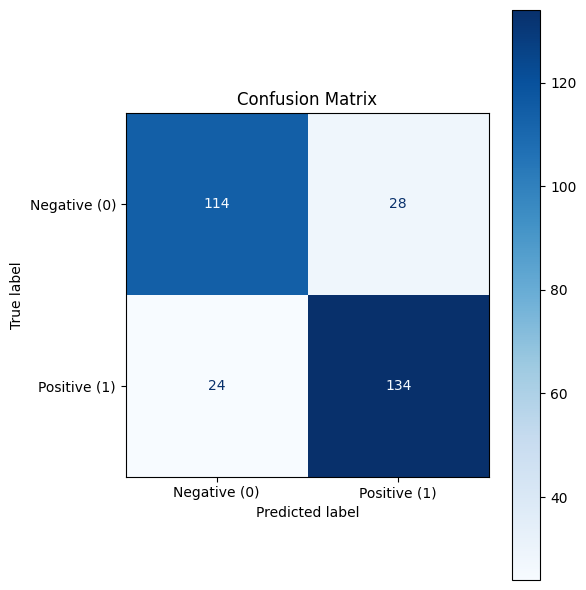

In [21]:
# Load best model
model = SimpleANNClassifier(input_size, model_name)
model.load_state_dict(torch.load(model.name))
model.to(device)

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

## Train simple ANN Classifier on large dataset

In [22]:
model_name ='amazonclasssimplelarge'
input_size = train_x_tensor_l.shape[1]
model = SimpleANNClassifier(input_size, model_name)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

trained_model = train_model(model, criterion, optimizer, train_loader_large, val_loader_large, num_epochs=25)

Epoch 1/25, Train Loss: 0.6233, Val Loss: 0.5444, Train Acc: 67.06%, Val Acc: 81.78%
Epoch 2/25, Train Loss: 0.5390, Val Loss: 0.4956, Train Acc: 76.55%, Val Acc: 84.42%
Epoch 3/25, Train Loss: 0.4890, Val Loss: 0.4576, Train Acc: 79.96%, Val Acc: 86.66%
Epoch 4/25, Train Loss: 0.4512, Val Loss: 0.4222, Train Acc: 81.90%, Val Acc: 87.50%
Epoch 5/25, Train Loss: 0.4200, Val Loss: 0.3944, Train Acc: 82.58%, Val Acc: 87.46%
Epoch 6/25, Train Loss: 0.3888, Val Loss: 0.3677, Train Acc: 84.30%, Val Acc: 87.58%
Epoch 7/25, Train Loss: 0.3697, Val Loss: 0.3463, Train Acc: 84.26%, Val Acc: 88.60%
Epoch 8/25, Train Loss: 0.3503, Val Loss: 0.3374, Train Acc: 85.03%, Val Acc: 87.74%
Epoch 9/25, Train Loss: 0.3283, Val Loss: 0.3228, Train Acc: 85.87%, Val Acc: 88.34%
Epoch 10/25, Train Loss: 0.3158, Val Loss: 0.3094, Train Acc: 85.96%, Val Acc: 88.56%
Epoch 11/25, Train Loss: 0.3054, Val Loss: 0.3027, Train Acc: 86.06%, Val Acc: 88.44%
Epoch 12/25, Train Loss: 0.2892, Val Loss: 0.2986, Train Acc: 8

C:\Users\JuliusAdmin\AppData\Local\Temp\ipykernel_26672\4165607280.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model.name))


Accuracy on testing dataset: 88.44%
F1-Score: 0.90


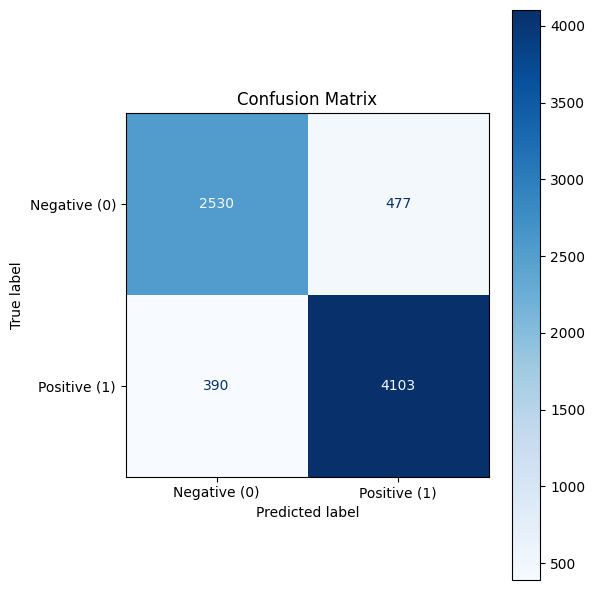

In [23]:
# Load best model
model = SimpleANNClassifier(input_size, model_name)
model.load_state_dict(torch.load(model.name))
model.to(device)

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_large, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

## Train ANN Classifier on large dataset

In [24]:
model_name_l = 'amazonclasslarge'
input_size = train_x_tensor_l.shape[1]
model = ANNClassifier(input_size, model_name_l)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

trained_model = train_model(model, criterion, optimizer, train_loader_large, val_loader_large, num_epochs=25)

Epoch 1/25, Train Loss: 0.5612, Val Loss: 0.4195, Train Acc: 70.56%, Val Acc: 85.30%
Epoch 2/25, Train Loss: 0.4119, Val Loss: 0.3417, Train Acc: 81.44%, Val Acc: 86.24%
Epoch 3/25, Train Loss: 0.3000, Val Loss: 0.3184, Train Acc: 87.06%, Val Acc: 86.78%
Epoch 4/25, Train Loss: 0.2355, Val Loss: 0.3048, Train Acc: 88.74%, Val Acc: 87.52%
Epoch 5/25, Train Loss: 0.2036, Val Loss: 0.3271, Train Acc: 89.74%, Val Acc: 87.52%
Epoch 6/25, Train Loss: 0.1931, Val Loss: 0.3665, Train Acc: 90.06%, Val Acc: 86.44%
Epoch 7/25, Train Loss: 0.1904, Val Loss: 0.3717, Train Acc: 89.80%, Val Acc: 86.46%
Epoch 8/25, Train Loss: 0.1893, Val Loss: 0.4132, Train Acc: 89.42%, Val Acc: 85.84%
Epoch 9/25, Train Loss: 0.1929, Val Loss: 0.4058, Train Acc: 89.46%, Val Acc: 86.30%
Epoch 10/25, Train Loss: 0.1961, Val Loss: 0.4302, Train Acc: 89.15%, Val Acc: 86.02%
Epoch 11/25, Train Loss: 0.1911, Val Loss: 0.4655, Train Acc: 89.46%, Val Acc: 85.50%
Epoch 12/25, Train Loss: 0.1826, Val Loss: 0.4685, Train Acc: 8

C:\Users\JuliusAdmin\AppData\Local\Temp\ipykernel_26672\2714124246.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model.name))


Accuracy on testing dataset: 87.78666666666666%
F1-Score: 0.90


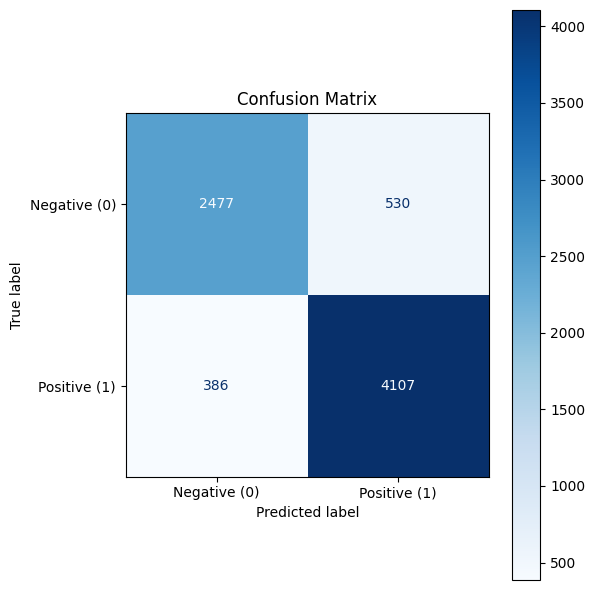

In [25]:
# Load best model
model = ANNClassifier(input_size, model_name_l)
model.load_state_dict(torch.load(model.name))
model.to(device)

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_large, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

---

## Train ANN with word embeddings
small dataset and small model

In [26]:
model_name ='amazonclasssimplew2v'
input_size = train_x_tensor_w2v.shape[1]
model = SimpleANNClassifier(input_size, model_name)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

trained_model = train_model(model, criterion, optimizer, train_loader_w2v, val_loader_w2v, num_epochs=500)

Epoch 1/500, Train Loss: 0.7020, Val Loss: 0.6689, Train Acc: 56.20%, Val Acc: 60.50%
Epoch 2/500, Train Loss: 0.6812, Val Loss: 0.6448, Train Acc: 55.40%, Val Acc: 65.50%
Epoch 3/500, Train Loss: 0.6606, Val Loss: 0.6309, Train Acc: 56.60%, Val Acc: 65.50%
Epoch 4/500, Train Loss: 0.6672, Val Loss: 0.6231, Train Acc: 58.00%, Val Acc: 66.50%
Epoch 5/500, Train Loss: 0.6446, Val Loss: 0.6090, Train Acc: 58.00%, Val Acc: 68.00%
Epoch 6/500, Train Loss: 0.6381, Val Loss: 0.6022, Train Acc: 61.80%, Val Acc: 68.50%
Epoch 7/500, Train Loss: 0.6336, Val Loss: 0.6002, Train Acc: 62.00%, Val Acc: 67.00%
Epoch 8/500, Train Loss: 0.6275, Val Loss: 0.5953, Train Acc: 61.00%, Val Acc: 66.50%
Epoch 9/500, Train Loss: 0.6245, Val Loss: 0.5935, Train Acc: 60.60%, Val Acc: 67.50%
Epoch 10/500, Train Loss: 0.6177, Val Loss: 0.5899, Train Acc: 66.60%, Val Acc: 68.00%
Epoch 11/500, Train Loss: 0.5996, Val Loss: 0.5880, Train Acc: 65.00%, Val Acc: 68.00%
Epoch 12/500, Train Loss: 0.6069, Val Loss: 0.5834, 

Accuracy on testing dataset: 71.33333333333333%
F1-Score: 0.73


C:\Users\JuliusAdmin\AppData\Local\Temp\ipykernel_26672\590513472.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model.name))


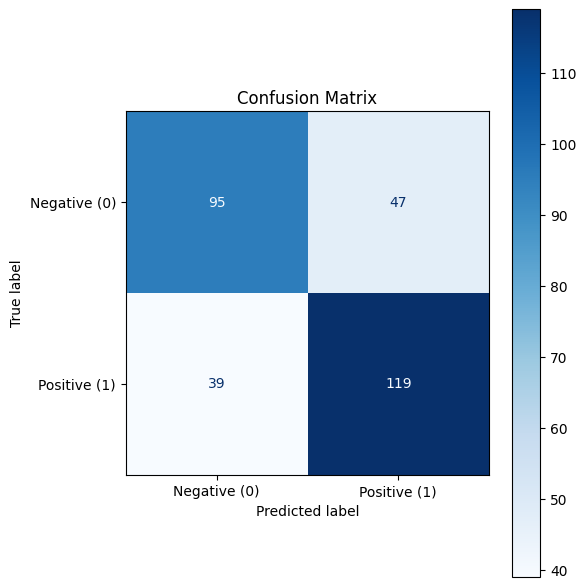

In [27]:
# Load best model
model = SimpleANNClassifier(input_size, model_name)
model.load_state_dict(torch.load(model.name))
model.to(device)

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_w2v, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

larger dataset and larger model

In [28]:
model_name ='amazonclasssimplew2vlarge'
input_size = train_x_tensor_w2v_l.shape[1]
model = ANNClassifierLarge(input_size, model_name)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

trained_model = train_model(model, criterion, optimizer, train_loader_w2v_l, val_loader_w2v_l, num_epochs=50)

Epoch 1/50, Train Loss: 0.5226, Val Loss: 0.4530, Train Acc: 73.72%, Val Acc: 78.00%
Epoch 2/50, Train Loss: 0.4666, Val Loss: 0.4457, Train Acc: 77.67%, Val Acc: 78.02%
Epoch 3/50, Train Loss: 0.4570, Val Loss: 0.4397, Train Acc: 77.82%, Val Acc: 78.58%
Epoch 4/50, Train Loss: 0.4501, Val Loss: 0.4460, Train Acc: 78.66%, Val Acc: 78.48%
Epoch 5/50, Train Loss: 0.4409, Val Loss: 0.4593, Train Acc: 79.06%, Val Acc: 76.00%
Epoch 6/50, Train Loss: 0.4320, Val Loss: 0.4347, Train Acc: 79.78%, Val Acc: 78.34%
Epoch 7/50, Train Loss: 0.4341, Val Loss: 0.4316, Train Acc: 79.67%, Val Acc: 78.64%
Epoch 8/50, Train Loss: 0.4277, Val Loss: 0.4872, Train Acc: 79.74%, Val Acc: 74.20%
Epoch 9/50, Train Loss: 0.4280, Val Loss: 0.4326, Train Acc: 79.78%, Val Acc: 79.00%
Epoch 10/50, Train Loss: 0.4226, Val Loss: 0.4352, Train Acc: 80.19%, Val Acc: 79.12%
Epoch 11/50, Train Loss: 0.4202, Val Loss: 0.4318, Train Acc: 80.86%, Val Acc: 79.30%
Epoch 12/50, Train Loss: 0.4119, Val Loss: 0.4591, Train Acc: 8

C:\Users\JuliusAdmin\AppData\Local\Temp\ipykernel_26672\331250792.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model.name))


Accuracy on testing dataset: 78.93333333333334%
F1-Score: 0.83


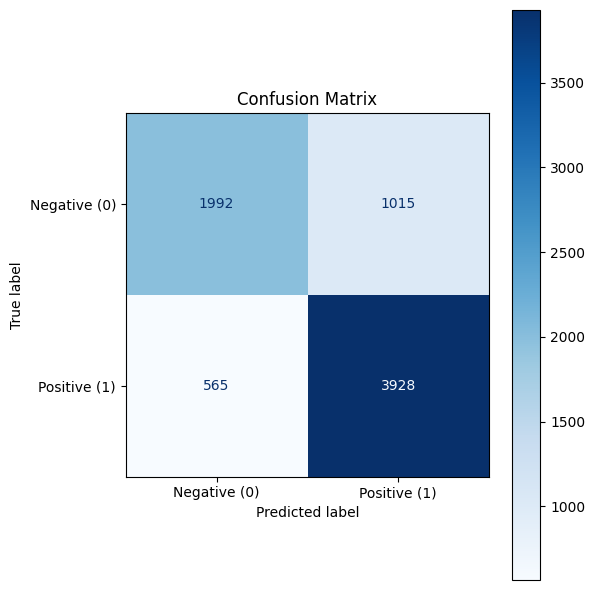

In [29]:
# Load best model
model = ANNClassifierLarge(input_size, model_name)
model.load_state_dict(torch.load(model.name))
model.to(device)

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_w2v_l, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

---

# Transformer